# Lab 11, Aleksandr Berezutskii, group 4, Skoltech 2018

In [1]:
import numpy as np
import matplotlib.pyplot as plt

The objective of this laboratory work is to develop a tracking filter to estimate a vehicle’s
dynamic state by assimilating the navigation data coming from different sources. The task
includes the fusion of GPS data (absolute positioning) and wheel odometry data (relative
positioning). Important outcome of this exercise is getting skill to solve the most fundamental
data fusion tasks for intelligent traffic applications.

### Part I. Assimilation of GPS data only (absolute positioning)

In [2]:
# Steps 1 and 2

#N is the size of trajectory
N = 500

#T is the interval between measurements
T = 0.05

#Theta is array of orientation angle
theta = np.loadtxt('theta.txt')

#Noise of acceleration
sigma_a = 1
a_x = np.random.normal(loc=0.0, scale=sigma_a, size=N)
a_y = np.random.normal(loc=0.0, scale=sigma_a, size=N)

#Now let's create the trajectory
x = np.zeros(N)
x[0] = 0

y = np.zeros(N)
y[0] = 0

v_x = np.zeros(N)
v_y = np.zeros(N)
v = 10

for i in range(N):
    v_x[i] = v * np.cos(theta[i])
    v_y[i] = v * np.sin(theta[i])

for i in range(1,N):
    x[i] = x[i-1] + v_x[i-1]*T + a_x[i-1]*(T**2)/2
    y[i] = y[i-1] + v_y[i-1]*T + a_y[i-1]*(T**2)/2

In [3]:
# Step 3

#Noise of measurements
sigma_eta_x = 3
sigma_eta_y = 3
eta_x = np.random.normal(loc=0.0, scale=sigma_eta_x, size=N)
eta_y = np.random.normal(loc=0.0, scale=sigma_eta_y, size=N)

#Now let's generate measurements
z_x = np.zeros(N)
z_y = np.zeros(N)
for i in range(N):
    z_x[i] = x[i] + eta_x[i]
    z_y[i] = y[i] + eta_y[i]

In [4]:
# Step 4

#Making measurement vector z
z = np.zeros((N, 2, 1))
for i in range(N):
    z[i] = np.matrix([[z_x[i]], 
                      [z_y[i]]])
    
#Making state vector
X = np.zeros((N, 4, 1))
for i in range(N):
    X[i] = np.matrix([[x[i]],
                      [v_x[i]],
                      [y[i]],
                      [v_y[i]]])
#Initial state vector
X[2] = np.matrix([[z_x[1]],
                  [(z_x[1] - z_x[0]) / T],
                  [z_y[1]],
                  [(z_y[1] - z_y[0]) / T]])

#Making filtration error covariance matrix P
P = np.zeros((N, 4, 4))
for i in range(N):
    P[i] = np.matrix([[0, 0, 0, 0],
                      [0, 0, 0, 0],
                      [0, 0, 0, 0],
                      [0, 0, 0, 0]])

#Initial filtration error covariance matrix
P[0] = 10**4 * np.identity(4)

#Making a transition matrix
PHI = np.matrix([[1, T, 0, 0],
                 [0, 1, 0, 0],
                 [0, 0, 1, T],
                 [0, 0, 0, 1]])

#Making an observation matrix
H = np.matrix([[1, 0, 0, 0], [0, 0, 1, 0]])

#Making an input matrix
G = np.matrix([[0.5 * T**2, 0],
               [T, 0],
               [0, 0.5 * T**2],
               [0, T]])

#Calculating state noise covariance matrix Q
Q = 25 * G @ G.T

#Making measurement error covariance matrix R
R = np.matrix([[sigma_eta_x**2, 0], 
               [0, sigma_eta_y**2]])

# Let's start Kalman filter algorithm
x_Kalman_Predict = np.zeros(N)
y_Kalman_Predict = np.zeros(N)
x_Kalman_Filter = np.zeros(N)
y_Kalman_Filter = np.zeros(N)
dhdx = np.zeros((N, 2, 4))

K = np.zeros((N, 4, 2))
e = np.zeros((N, 2, 2))
for i in range(N):
    K[i] = np.matrix([[0, 0],
                     [0, 0],
                     [0, 0],
                     [0, 0]])
    e[i] = np.matrix([[0, 0],
                     [0, 0]])
    
#Making nonlinear function h
h = np.zeros((N, 2, 1))
sqrt = np.zeros(N)

for i in range(2, N-1):
    
    #Prediction of the state vector
    X[i+1] = PHI @ X[i]
    x_Kalman_Predict[i+1] = X[i+1,0]
    y_Kalman_Predict[i+1] = X[i+1,2]
    #sqrt[i+1] = (x_Kalman_Predict[i+1]**2 + y_Kalman_Predict[i+1]) ** 0.5
    
    #dhdx[i+1] = np.matrix([[x_Kalman_Predict[i+1]/sqrt[i+1], 0, y_Kalman_Predict[i+1]/sqrt[i+1], 0], 
                           #[y_Kalman_Predict[i+1] / sqrt[i+1]**2, 0, -x_Kalman_Predict[i+1] / sqrt[i+1]**2, 0]])
    
    #Prediction error covariance matrix
    P[i+1] = PHI @ P[i] @ PHI.T + Q
    
    #Filtration
    #K[i+1] = P[i+1] @ dhdx[i+1].T @ np.linalg.inv(dhdx[i+1] @ P[i+1] @ dhdx[i+1].T + R)
    K[i+1] = P[i+1] @ H.T @ np.linalg.inv((H @ P[i+1] @ H.T + R))
    #h[i+1] = np.matrix([[x_Kalman_Predict[i+1]], 
                      #[y_Kalman_Predict[i+1]]])
    #X[i+1] = X[i+1] + K[i+1] @ (z[i+1] - h[i+1])
    X[i+1] = X[i+1] + K[i+1] @ (z[i+1] - H@ X[i+1])
    x_Kalman_Filter[i+1] = X[i+1,0]
    y_Kalman_Filter[i+1] = X[i+1,2]
    
    #Filtration error covariance matrix
    P[i+1] = (np.identity(np.shape(P[0])[0]) - K[i+1] @ H) @ P[i+1]
    #P[i+1] = (np.identity(np.shape(P[0])[0]) - K[i+1] @ dhdx[i+1]) @ P[i+1]

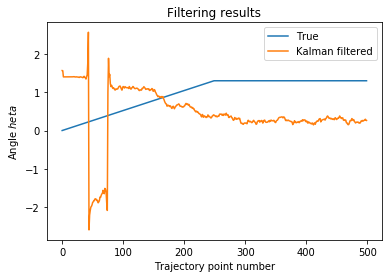

In [5]:
plt.plot(theta)
plt.plot(np.arctan2(X[:, 1], X[:, 3]))
plt.xlabel('Trajectory point number')
plt.ylabel('Angle $\theta$')
plt.title('Filtering results')
plt.legend(['True', 'Kalman filtered'], loc = 'best')
plt.show()

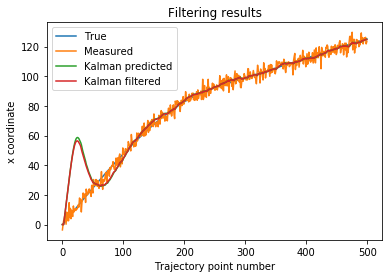

In [6]:
plt.plot(x)
plt.plot(z_x)
plt.plot(x_Kalman_Predict)
plt.plot(x_Kalman_Filter)
plt.xlabel('Trajectory point number')
plt.ylabel('x coordinate')
plt.title('Filtering results')
plt.legend(['True', 'Measured', 'Kalman predicted', 'Kalman filtered'], loc = 'best')
plt.show()

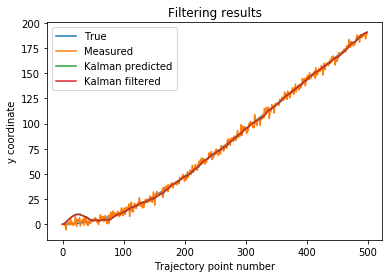

In [7]:
plt.plot(y)
plt.plot(z_y)
plt.plot(y_Kalman_Predict)
plt.plot(y_Kalman_Filter)
plt.xlabel('Trajectory point number')
plt.ylabel('y coordinate')
plt.title('Filtering results')
plt.legend(['True', 'Measured', 'Kalman predicted', 'Kalman filtered'], loc = 'best')
plt.show()

In [8]:
# Step 5

# M is the total number of runs
M=500
Errors_prediction_squared_x = np.zeros((M, N))
Errors_filtration_squared_x = np.zeros((M, N))
Errors_prediction_squared_y = np.zeros((M, N))
Errors_filtration_squared_y = np.zeros((M, N))

for j in range(M):
    
    #N is the size of trajectory
    N = 500

    #T is the interval between measurements
    T = 0.05

    #Theta is array of orientation angle
    theta = np.loadtxt('theta.txt')

    #Noise of acceleration
    sigma_a = 1
    a_x = np.random.normal(loc=0.0, scale=sigma_a, size=N)
    a_y = np.random.normal(loc=0.0, scale=sigma_a, size=N)

    #Now let's create the trajectory
    x = np.zeros(N)
    x[0] = 0

    y = np.zeros(N)
    y[0] = 0

    v_x = np.zeros(N)
    v_y = np.zeros(N)
    v = 10

    for i in range(N):
        v_x[i] = v * np.cos(theta[i])
        v_y[i] = v * np.sin(theta[i])

    for i in range(1,N):
        x[i] = x[i-1] + v_x[i-1]*T + a_x[i-1]*(T**2)/2
        y[i] = y[i-1] + v_y[i-1]*T + a_y[i-1]*(T**2)/2

    #Noise of measurements
    sigma_eta_x = 3
    sigma_eta_y = 3
    eta_x = np.random.normal(loc=0.0, scale=sigma_eta_x, size=N)
    eta_y = np.random.normal(loc=0.0, scale=sigma_eta_y, size=N)

    #Now let's generate measurements
    z_x = np.zeros(N)
    z_y = np.zeros(N)
    for i in range(N):
        z_x[i] = x[i] + eta_x[i]
        z_y[i] = y[i] + eta_y[i]

    #Making measurement vector z
    z = np.zeros((N, 2, 1))
    for i in range(N):
        z[i] = np.matrix([[z_x[i]], 
                          [z_y[i]]])

    #Making state vector
    X = np.zeros((N, 4, 1))
    for i in range(N):
        X[i] = np.matrix([[x[i]],
                          [v_x[i]],
                          [y[i]],
                          [v_y[i]]])
    #Initial state vector
    X[2] = np.matrix([[z_x[1]],
                      [(z_x[1] - z_x[0]) / T],
                      [z_y[1]],
                      [(z_y[1] - z_y[0]) / T]])

    #Making filtration error covariance matrix P
    P = np.zeros((N, 4, 4))
    for i in range(N):
        P[i] = np.matrix([[0, 0, 0, 0],
                          [0, 0, 0, 0],
                          [0, 0, 0, 0],
                          [0, 0, 0, 0]])

    #Initial filtration error covariance matrix
    P[0] = 10**4 * np.identity(4)

    #Making a transition matrix
    PHI = np.matrix([[1, T, 0, 0],
                     [0, 1, 0, 0],
                     [0, 0, 1, T],
                     [0, 0, 0, 1]])

    #Making an observation matrix
    H = np.matrix([[1, 0, 0, 0], [0, 0, 1, 0]])

    #Making an input matrix
    G = np.matrix([[0.5 * T**2, 0],
                   [T, 0],
                   [0, 0.5 * T**2],
                   [0, T]])

    #Calculating state noise covariance matrix Q
    Q = 25 * G @ G.T

    #Making measurement error covariance matrix R
    R = np.matrix([[sigma_eta_x**2, 0], 
                   [0, sigma_eta_y**2]])

    # Let's start Kalman filter algorithm
    x_Kalman_Predict = np.zeros(N)
    y_Kalman_Predict = np.zeros(N)
    x_Kalman_Filter = np.zeros(N)
    y_Kalman_Filter = np.zeros(N)
    dhdx = np.zeros((N, 2, 4))

    K = np.zeros((N, 4, 2))
    e = np.zeros((N, 2, 2))
    for i in range(N):
        K[i] = np.matrix([[0, 0],
                         [0, 0],
                         [0, 0],
                         [0, 0]])
        e[i] = np.matrix([[0, 0],
                         [0, 0]])

    #Making nonlinear function h
    h = np.zeros((N, 2, 1))
    sqrt = np.zeros(N)

    for i in range(2, N-1):

        #Prediction of the state vector
        X[i+1] = PHI @ X[i]
        x_Kalman_Predict[i+1] = X[i+1,0]
        y_Kalman_Predict[i+1] = X[i+1,2]
        #sqrt[i+1] = (x_Kalman_Predict[i+1]**2 + y_Kalman_Predict[i+1]) ** 0.5

        #dhdx[i+1] = np.matrix([[x_Kalman_Predict[i+1]/sqrt[i+1], 0, y_Kalman_Predict[i+1]/sqrt[i+1], 0], 
                               #[y_Kalman_Predict[i+1] / sqrt[i+1]**2, 0, -x_Kalman_Predict[i+1] / sqrt[i+1]**2, 0]])

        #Prediction error covariance matrix
        P[i+1] = PHI @ P[i] @ PHI.T + Q

        #Filtration
        #K[i+1] = P[i+1] @ dhdx[i+1].T @ np.linalg.inv(dhdx[i+1] @ P[i+1] @ dhdx[i+1].T + R)
        K[i+1] = P[i+1] @ H.T @ np.linalg.inv((H @ P[i+1] @ H.T + R))
        #h[i+1] = np.matrix([[x_Kalman_Predict[i+1]], 
                          #[y_Kalman_Predict[i+1]]])
        #X[i+1] = X[i+1] + K[i+1] @ (z[i+1] - h[i+1])
        X[i+1] = X[i+1] + K[i+1] @ (z[i+1] - H@ X[i+1])
        x_Kalman_Filter[i+1] = X[i+1,0]
        y_Kalman_Filter[i+1] = X[i+1,2]

        #Filtration error covariance matrix
        P[i+1] = (np.identity(np.shape(P[0])[0]) - K[i+1] @ H) @ P[i+1]
        #P[i+1] = (np.identity(np.shape(P[0])[0]) - K[i+1] @ dhdx[i+1]) @ P[i+1]
        
          #Errors gathering
        for i in range(3, N-1):
            Errors_prediction_squared_x[j, i] = (x_Kalman_Predict[i] - z_x[i])**2
            Errors_filtration_squared_x[j, i] = (x_Kalman_Filter[i] - z_x[i])**2
            Errors_prediction_squared_y[j, i] = (y_Kalman_Predict[i] - z_y[i])**2
            Errors_filtration_squared_y[j, i] = (y_Kalman_Filter[i] - z_y[i])**2
            

Fin_Err_prediction_squared_x = np.zeros(N)
Fin_Err_filtration_squared_x = np.zeros(N)
Fin_Err_prediction_squared_y = np.zeros(N)
Fin_Err_filtration_squared_y = np.zeros(N)
for i in range(N-1):
    for j in range(M):
        Fin_Err_prediction_squared_x[i] += (1/(M-1))*Errors_prediction_squared_x[j, i]
        Fin_Err_filtration_squared_x[i] += (1/(M-1))*Errors_filtration_squared_x[j, i]
        Fin_Err_prediction_squared_y[i] += (1/(M-1))*Errors_prediction_squared_y[j, i]
        Fin_Err_filtration_squared_y[i] += (1/(M-1))*Errors_filtration_squared_y[j, i]

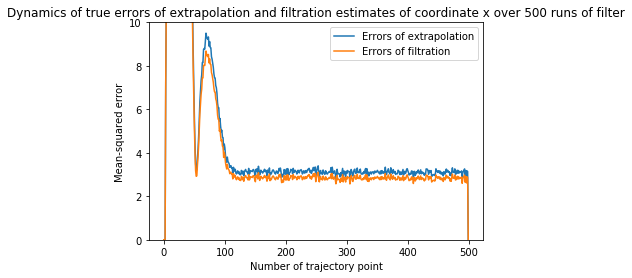

In [9]:
plt.plot(np.sqrt(Fin_Err_prediction_squared_x))
plt.plot(np.sqrt(Fin_Err_filtration_squared_x))
plt.title('Dynamics of true errors of extrapolation and filtration estimates of coordinate x over 500 runs of filter')
plt.ylabel('Mean-squared error')
plt.xlabel('Number of trajectory point')
plt.legend(['Errors of extrapolation', 'Errors of filtration'], loc = 'best')
plt.ylim((0,10))
plt.show()

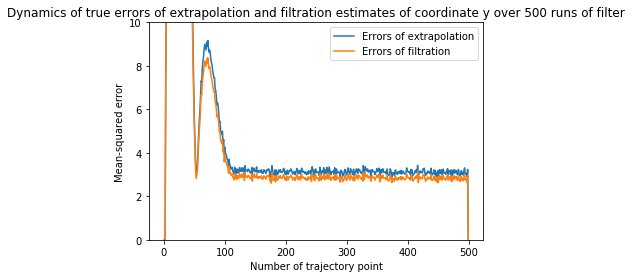

In [10]:
plt.plot(np.sqrt(Fin_Err_prediction_squared_y))
plt.plot(np.sqrt(Fin_Err_filtration_squared_y))
plt.title('Dynamics of true errors of extrapolation and filtration estimates of coordinate y over 500 runs of filter')
plt.ylabel('Mean-squared error')
plt.xlabel('Number of trajectory point')
plt.legend(['Errors of extrapolation', 'Errors of filtration'], loc = 'best')
plt.ylim((0,10))
plt.show()

### Part II. Assimilation of both GPS data (absolute positioning) and wheel odometry data (relative positioning).

In [23]:
#Step 1

#N is the size of trajectory
N = 500

#T is the interval between measurements
T = 0.05

#Theta is array of orientation angle
theta = np.loadtxt('theta.txt')

#Noise of acceleration
sigma_a = 1
a_x = np.random.normal(loc=0.0, scale=sigma_a, size=N)
a_y = np.random.normal(loc=0.0, scale=sigma_a, size=N)

#Now let's create the trajectory
x = np.zeros(N)
x[0] = 0

y = np.zeros(N)
y[0] = 0

v_x = np.zeros(N)
v_y = np.zeros(N)
v0 = 10

for i in range(N):
    v_x[i] = v0 * np.cos(theta[i])
    v_y[i] = v0 * np.sin(theta[i])

for i in range(1,N):
    x[i] = x[i-1] + v_x[i-1]*T + a_x[i-1]*(T**2)/2
    y[i] = y[i-1] + v_y[i-1]*T + a_y[i-1]*(T**2)/2

In [24]:
# Step 2

#Noise of measurements
sigma_eta_x = 3
sigma_eta_y = 3
eta_x = np.random.normal(loc=0.0, scale=sigma_eta_x, size=N)
eta_y = np.random.normal(loc=0.0, scale=sigma_eta_y, size=N)

#Now let's generate measurements
z_x = np.zeros(N)
z_y = np.zeros(N)
for i in range(N):
    z_x[i] = x[i] + eta_x[i]
    z_y[i] = y[i] + eta_y[i]

In [25]:
# Step 3

#Noise of velocity measurements
sigma_eta_v = 0.5
eta_v = np.random.normal(loc=0.0, scale=sigma_eta_v, size=N)

#Now let's generate measurements
v_m = np.zeros(N)
for i in range(N):
    v_m[i] = v0 + eta_v[i]

In [26]:
# Step 4

#Noise of angle measurements
sigma_eta_theta = 0.02
eta_theta = np.random.normal(loc=0.0, scale=sigma_eta_theta, size=N)

#Now let's generate measurements
theta_m = np.zeros(N)
for i in range(N):
    theta_m[i] = theta[i] + eta_theta[i]

In [34]:
# Step 5
    
#Making state vector
X = np.zeros((N, 4, 1))
for i in range(N):
    X[i] = np.matrix([[x[i]],
                      [v_x[i]],
                      [y[i]],
                      [v_y[i]]])
#Initial state vector
X[2] = np.matrix([[z_x[1]],
                  [(z_x[1] - z_x[0]) / T],
                  [z_y[1]],
                  [(z_y[1] - z_y[0]) / T]])

#Making filtration error covariance matrix P
P = np.zeros((N, 4, 4))
for i in range(N):
    P[i] = np.matrix([[0, 0, 0, 0],
                      [0, 0, 0, 0],
                      [0, 0, 0, 0],
                      [0, 0, 0, 0]])

#Initial filtration error covariance matrix
P[0] = 10**4 * np.identity(4)

#Making a transition matrix
PHI = np.matrix([[1, T, 0, 0],
                 [0, 1, 0, 0],
                 [0, 0, 1, T],
                 [0, 0, 0, 1]])

#Making an input matrix
G = np.matrix([[0.5 * T**2, 0],
               [T, 0],
               [0, 0.5 * T**2],
               [0, T]])

#Calculating state noise covariance matrix Q
Q = 25 * G @ G.T

#Making measurement error covariance matrix R
R = np.matrix([[sigma_eta_x**2, 0, 0, 0],
               [0, sigma_eta_y**2, 0, 0],
               [0, 0, sigma_eta_v**2, 0],
               [0, 0, 0, sigma_eta_theta**2]])

# Let's start Kalman filter algorithm
x_Kalman_Predict = np.zeros(N)
y_Kalman_Predict = np.zeros(N)
x_Kalman_Filter = np.zeros(N)
y_Kalman_Filter = np.zeros(N)
vx_Kalman_Predict = np.zeros(N)
vy_Kalman_Predict = np.zeros(N)
vx_Kalman_Filter = np.zeros(N)
vy_Kalman_Filter = np.zeros(N)
dhdx = np.zeros((N, 2, 4))

K = np.zeros((N, 4, 4))
e = np.zeros((N, 2, 2))
    
#Making nonlinear function h, the derivative and measurement vector
h = np.zeros((N, 4, 1))
dhdx = np.zeros((N, 4, 4))
z = np.zeros((N, 4, 1))

sqrt = np.zeros(N)

for i in range(2, N-1):
    
    #Prediction of the state vector
    X[i+1] = PHI @ X[i]
    x_Kalman_Predict[i+1] = X[i+1,0]
    vx_Kalman_Predict[i+1] = X[i+1,1]
    y_Kalman_Predict[i+1] = X[i+1,2]
    vy_Kalman_Predict[i+1] = X[i+1,3]
    sqrt[i+1] = (vx_Kalman_Predict[i+1]**2 + vy_Kalman_Predict[i+1]**2) ** 0.5
    
    dhdx[i+1] = np.matrix([[1, 0, 0, 0],
                           [0, 0, 1, 0],
                           [0, vx_Kalman_Predict[i+1] / sqrt[i+1], 0, vy_Kalman_Predict[i+1]/sqrt[i+1]],
                           [0, -vy_Kalman_Predict[i+1] / (sqrt[i+1]**2), 0, vx_Kalman_Predict[i+1] / (sqrt[i+1]**2)]])
    
    #Prediction error covariance matrix
    P[i+1] = PHI @ P[i] @ PHI.T + Q
    
    #Filtration
    K[i+1] = P[i+1] @ dhdx[i+1].T @ np.linalg.inv(dhdx[i+1] @ P[i+1] @ dhdx[i+1].T + R)
    h[i+1] = np.matrix([[x_Kalman_Predict[i+1]],
                        [y_Kalman_Predict[i+1]],
                        [sqrt[i+1]],
                        [np.arctan2(vy_Kalman_Predict[i+1], vx_Kalman_Predict[i+1])]])
    z[i+1] = np.matrix([[z_x[i+1]], 
                      [z_y[i+1]],
                      [v_m[i+1]],
                      [theta_m[i+1]]])
    X[i+1] = X[i+1] + K[i+1] @ (z[i+1] - h[i+1])
    x_Kalman_Filter[i+1] = X[i+1,0]
    vx_Kalman_Filter[i+1] = X[i+1,1]
    y_Kalman_Filter[i+1] = X[i+1,2]
    vy_Kalman_Filter[i+1] = X[i+1,3]
    
    #Filtration error covariance matrix
    P[i+1] = (np.identity(np.shape(P[0])[0]) - K[i+1] @ dhdx[i+1]) @ P[i+1]

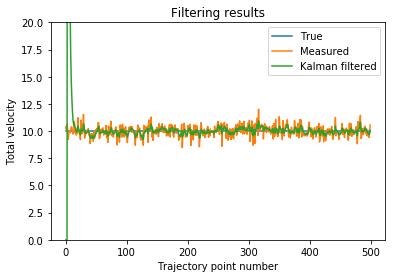

In [42]:
plt.plot(np.sqrt(v_x**2 + v_y**2))
plt.plot(v_m)
plt.plot(np.sqrt(vx_Kalman_Filter**2 + vy_Kalman_Filter**2))
plt.xlabel('Trajectory point number')
plt.ylabel('Total velocity')
plt.title('Filtering results')
plt.legend(['True', 'Measured', 'Kalman filtered'], loc = 'best')
plt.ylim((0, 20))
plt.show()

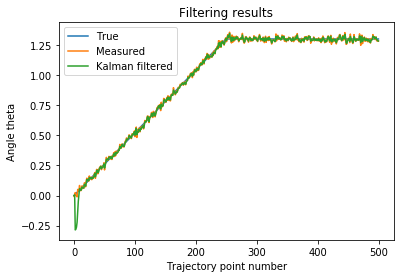

In [43]:
plt.plot(theta)
plt.plot(theta_m)
plt.plot(np.arctan2(X[:, 3], X[:, 1]))
plt.xlabel('Trajectory point number')
plt.ylabel('Angle theta')
plt.title('Filtering results')
plt.legend(['True', 'Measured', 'Kalman filtered'], loc = 'best')
plt.show()

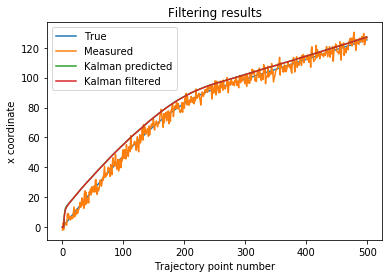

In [45]:
plt.plot(x)
plt.plot(z_x)
plt.plot(x_Kalman_Predict)
plt.plot(x_Kalman_Filter)
plt.xlabel('Trajectory point number')
plt.ylabel('x coordinate')
plt.title('Filtering results')
plt.legend(['True', 'Measured', 'Kalman predicted', 'Kalman filtered'], loc = 'best')
plt.show()

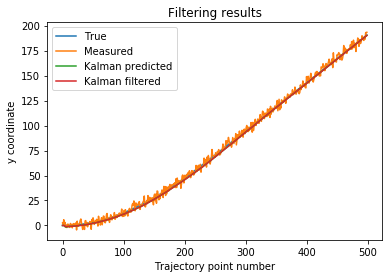

In [46]:
plt.plot(y)
plt.plot(z_y)
plt.plot(y_Kalman_Predict)
plt.plot(y_Kalman_Filter)
plt.xlabel('Trajectory point number')
plt.ylabel('y coordinate')
plt.title('Filtering results')
plt.legend(['True', 'Measured', 'Kalman predicted', 'Kalman filtered'], loc = 'best')
plt.show()

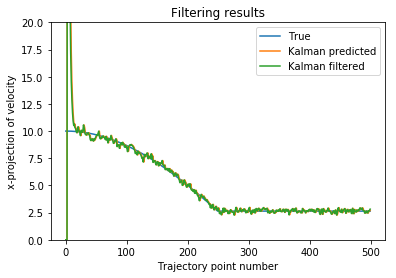

In [47]:
plt.plot(v_x)
plt.plot(vx_Kalman_Predict)
plt.plot(vx_Kalman_Filter)
plt.xlabel('Trajectory point number')
plt.ylabel('x-projection of velocity')
plt.title('Filtering results')
plt.legend(['True', 'Kalman predicted', 'Kalman filtered'], loc = 'best')
plt.ylim((0, 20))
plt.show()

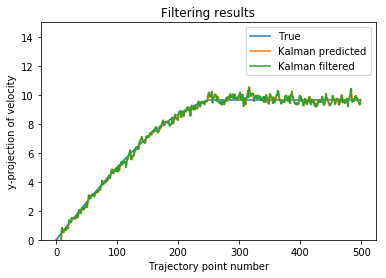

In [48]:
plt.plot(v_y)
plt.plot(vy_Kalman_Predict)
plt.plot(vy_Kalman_Filter)
plt.xlabel('Trajectory point number')
plt.ylabel('y-projection of velocity')
plt.title('Filtering results')
plt.legend(['True', 'Kalman predicted', 'Kalman filtered'], loc = 'best')
plt.ylim((0, 15))
plt.show()